In [20]:
import seaborn as sns
import torch
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from collections import OrderedDict
sns.set_style('darkgrid')

## Analysis for attack
- Load model and verify everything is correct or not

In [3]:
data = torch.load('../savedir/CIFAR_ddb_fas_cummul_highfreq_remove.pth', map_location='cpu')

# del data['images']
# data['lip'] = torch.load('../savedir/TIMGNET_ddb_lip.pth')['lip']
# no_img_df = {'ddbs': data['ddbs'], 'FAS_score': data['FAS_score'], 
#                 'steps_to_atk': data['steps_to_atk'], 'predictions': data['predictions'] }
df = pd.DataFrame(data)
# df['FAS_score_5_round'] = df['FAS_score_5'].apply(lambda x: int(x))
df['ddbs'] = list(map(lambda x:float(x), df['ddbs']))
df = df[(df['gt'] == df['Model_preds'])]
for k, v in df.items():
    if type(v) == list:
        print(f'{k} \t {len(v)}')
    else:
        print(f'{k}  \t {v.shape}')


ddbs  	 (48008,)
gt  	 (48008,)
steps_to_atk  	 (48008,)
predictions  	 (48008,)
Flipping_Freq  	 (48008,)
Model_preds  	 (48008,)
lip  	 (48008,)


### Histogram of Steps required to attack a sample
- PS. y axis is in log scale

 18    3381
 17    3376
 16    3239
 19    3134
 20    2687
 15    2660
 21    2285
 14    2269
 22    1899
 13    1828
 7     1599
 12    1586
 8     1560
 23    1504
 9     1444
 11    1424
 6     1407
 10    1384
 4     1169
 24    1095
 5     1071
 25     889
 3      782
 26     667
 2      576
 27     524
 31     523
 1      515
 30     414
 28     407
 29     376
 0      332
-1        2
Name: Flipping_Freq, dtype: int64

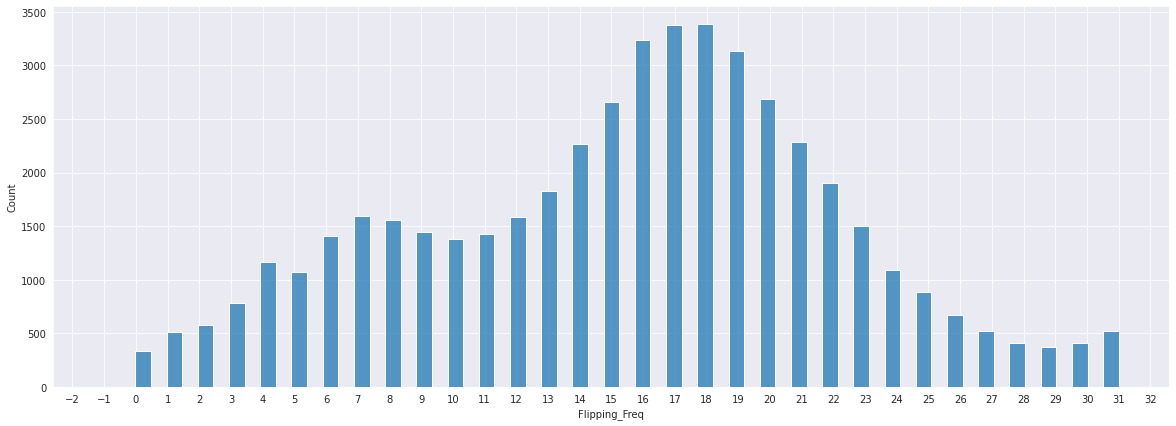

In [4]:
plt.figure(figsize=(20,7))
g = sns.histplot(data=df, x="Flipping_Freq")
# plt.figure(figsize=(20,7))
# h = sns.histplot(data=df, x="FAS_score"00)

# h.set_yscale("log")
# g.set_yscale("log")
g.xaxis.set_major_locator(ticker.MultipleLocator(1))
y = df['Flipping_Freq'].value_counts()
df['Flipping_Freq'].value_counts()

### Correlation between ddbs and locallip

Correlation: (-0.4545539781800791, 0.0)


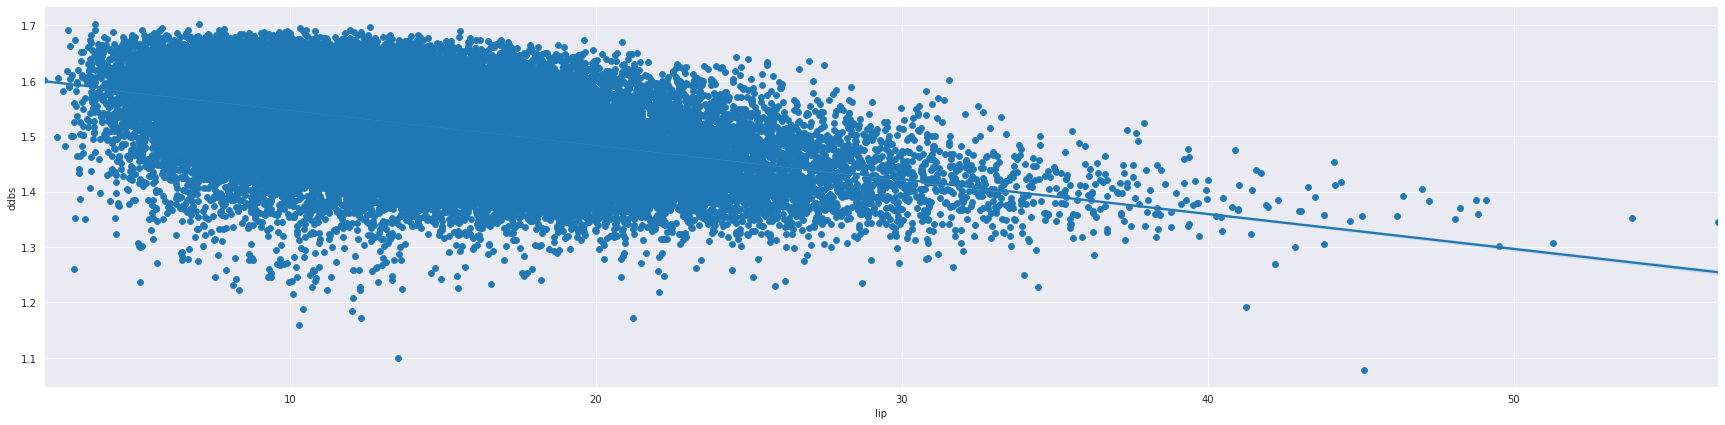

In [13]:
# plt.subplots(figsize=(5, 10))
# h = sns.scatterplot(data=data, y='ddbs', x='lip', hue='FAS_score')
# h.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.figure(figsize=(30, 7))
h = sns.scatterplot(data= df, y='ddbs', x='lip')
h = sns.regplot(data= df, y='ddbs', x='lip')
print('Correlation:', scipy.stats.pearsonr(df['ddbs'], df['lip']))

Correlation: (-0.0030505328036835406, 0.5038922739860797)


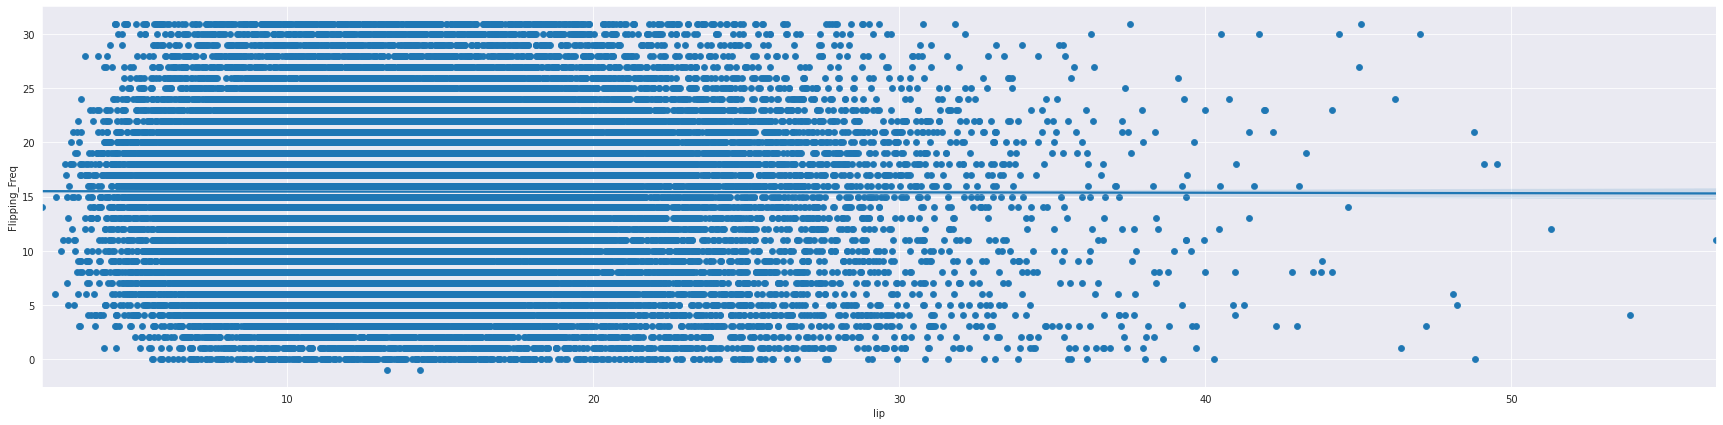

In [15]:
# plt.figure(figsize=(7,5))
plt.figure(figsize=(30, 7))
ax1 = sns.scatterplot(data=df, y ='Flipping_Freq', x='lip')
ax1 = sns.regplot(data=df, y ='Flipping_Freq', x='lip')
print('Correlation:', scipy.stats.pearsonr(df['Flipping_Freq'], df['lip']))
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

Correlation: (0.09986168710715504, 1.2123996818498933e-106)


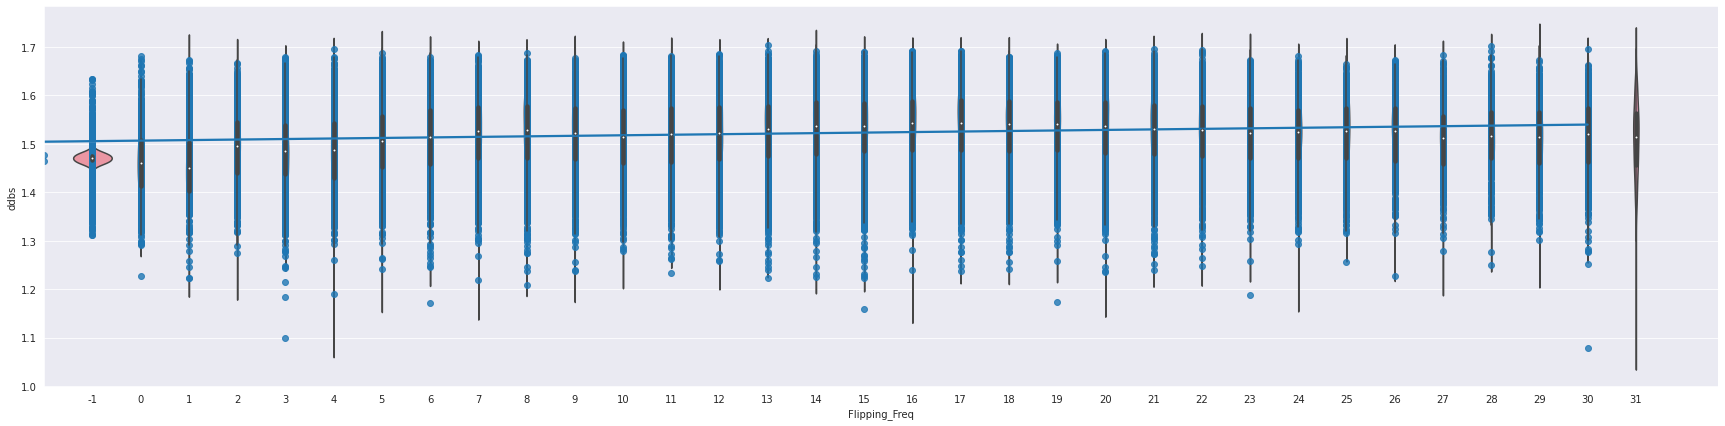

In [16]:
plt.figure(figsize=(30,7))
# median_ddbs = np.median(df.ddbs)
# median_fas = np.median(df.Flipping_Freq)
# print(f'DDB median: {median_ddbs}')
# print(f'FAS median: {median_fas}')

sns.violinplot(data=df, x ='Flipping_Freq', y='ddbs')
sns.regplot(data=df, x ='Flipping_Freq', y='ddbs')
print('Correlation:', scipy.stats.pearsonr(df['Flipping_Freq'], df['ddbs']))

# plt.axhline(median_fas)
# plt.axvline(median_ddbs)



## Quadrant Analysis

In [18]:
quads = OrderedDict()

median_ddbs = np.median(df.ddbs)
median_fas = np.median(df.Flipping_Freq)
print(f'DDB median: {median_ddbs}')
print(f'Flip_freq median: {median_fas}')

quads['HF + FDB'] = df[(df['Flipping_Freq'] > median_fas) & (df['ddbs'] > median_ddbs)]
quads['LF + FDB'] = df[(df['Flipping_Freq'] < median_fas) & (df['ddbs'] > median_ddbs)]
quads['LF + CBD'] = df[(df['Flipping_Freq'] < median_fas) & (df['ddbs'] < median_ddbs)]
quads['HF + CBD'] = df[(df['Flipping_Freq'] > median_fas) & (df['ddbs'] < median_ddbs)]

quad_analysis = {}
# myTable = PrettyTable()
for k in quads.keys():
    quad_analysis[k] = [int(len(quads[k])),
                    np.round_(np.mean(quads[k].Flipping_Freq), decimals=2), 
                    np.round_(np.mean(quads[k].ddbs), decimals=2), 
                    np.round_(np.mean(quads[k].steps_to_atk), decimals=2),
                    np.round_(np.mean(quads[k].lip), decimals=2)
                    ]
df_quad_analysis = pd.DataFrame(quad_analysis)
df_quad_analysis.index = ["Samples", "flip freq Av", "ddb Av", "stp Av",'Lip Av']
df_quad_analysis
    # print(f'Quadrant {k} - \t Data points: {len(quads[k])} \t FAS_Avg: {np.mean(quads[k].FAS_score)}')

DDB median: 1.527528703212738
Flip_freq median: 16.0


,HF + FDB,LF + FDB,LF + CBD,HF + CBD
Samples,12222.00,9906.00,11702.00,10939.00
flip freq Av,20.72,10.13,8.78,21.35
ddb Av,1.58,1.58,1.46,1.47
stp Av,1.03,1.43,1.04,0.79
Lip Av,12.41,11.81,16.04,16.26


In [19]:
quads = OrderedDict()
# for i in range(df['FAS_score'])

median_ddbs = np.median(df.ddbs)
median_fas = np.median(df.Flipping_Freq)
print(f'DDB median: {median_ddbs}')
print(f'Flip_freq median: {median_fas}')

quads['HF'] = df[(df['Flipping_Freq'] > median_fas)]
quads['LF'] = df[(df['Flipping_Freq'] < median_fas)]
# quads['LF + CBD'] = df[(df['Flipping_Freq'] < median_fas) & (df['ddbs'] < median_ddbs)]
# quads['HF + CBD'] = df[(df['Flipping_Freq'] > median_fas) & (df['ddbs'] < median_ddbs)]

quad_analysis = {}
# myTable = PrettyTable()
for k in quads.keys():
    quad_analysis[k] = [int(len(quads[k])),
                    np.round_(np.mean(quads[k].Flipping_Freq), decimals=2), 
                    np.round_(np.mean(quads[k].ddbs), decimals=2), 
                    np.round_(np.mean(quads[k].steps_to_atk), decimals=2),
                    np.round_(np.mean(quads[k].lip), decimals=2)
                    ]
df_quad_analysis = pd.DataFrame(quad_analysis)
df_quad_analysis.index = ["Samples", "flip freq Av", "ddb Av", "stp Av",'Lip Av']
df_quad_analysis
    # print(f'Quadrant {k} - \t Data points: {len(quads[k])} \t FAS_Avg: {np.mean(quads[k].FAS_score)}')

DDB median: 1.527528703212738
Flip_freq median: 16.0


,HF,LF
Samples,23161.00,21608.00
flip freq Av,21.02,9.40
ddb Av,1.53,1.51
stp Av,0.92,1.22
Lip Av,14.23,14.10
